In [21]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import torchvision
import numpy as np
from torch.autograd import Variable
import random
%matplotlib inline
print(torch.__version__)

1.4.0


In [5]:
transform = transforms.Compose([
transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

In [6]:
data_train = datasets.MNIST(root = "./data/",
                            transform=transform,
                            train = True,
                            download = True)

data_test = datasets.MNIST(root="./data/",
                           transform = transform,
                           train = False)

In [7]:
data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size = 64,
                                                shuffle = True,
                                                num_workers=2)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size = 64,
                                               shuffle = True,
                                               num_workers=2)

In [8]:
print(len(data_train))
print(len(data_test))

60000
10000


[tensor(9), tensor(3), tensor(0), tensor(1), tensor(2), tensor(4), tensor(6), tensor(8), tensor(1), tensor(1), tensor(2), tensor(3), tensor(0), tensor(7), tensor(0), tensor(0), tensor(1), tensor(3), tensor(9), tensor(4), tensor(1), tensor(1), tensor(2), tensor(9), tensor(0), tensor(0), tensor(1), tensor(4), tensor(6), tensor(2), tensor(1), tensor(3), tensor(0), tensor(8), tensor(8), tensor(1), tensor(9), tensor(5), tensor(9), tensor(0), tensor(2), tensor(8), tensor(7), tensor(2), tensor(9), tensor(5), tensor(7), tensor(1), tensor(4), tensor(1), tensor(8), tensor(6), tensor(1), tensor(8), tensor(7), tensor(0), tensor(1), tensor(3), tensor(4), tensor(3), tensor(2), tensor(7), tensor(7), tensor(7)]


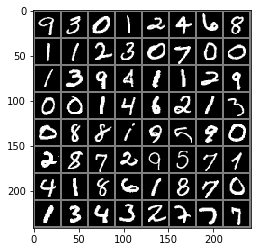

In [9]:
images, labels = next(iter(data_loader_train))
img = torchvision.utils.make_grid(images)

img = img.numpy().transpose(1,2,0)
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean
print([labels[i] for i in range(64)])
plt.imshow(img)

In [10]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1),
                                         torch.nn.ReLU(),
                                         torch.nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d(stride=2,kernel_size=2))
        self.dense = torch.nn.Sequential(torch.nn.Linear(14*14*128,1024),
                                         torch.nn.ReLU(),
                                         torch.nn.Dropout(p=0.5),
                                         torch.nn.Linear(1024, 10))
    def forward(self, x):
        x = self.conv1(x)
        #x = self.conv2(x)
        x = x.view(-1, 14*14*128)
        x = self.dense(x)
        return x

In [11]:
model = Model()

In [12]:
print(model)

Model(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=25088, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [13]:
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 5
#model.load_state_dict(torch.load('model_parameter.pkl'))

In [18]:
for epoch in range(n_epochs):
    running_loss = 0.0
    running_correct = 0
    print("Epoch {}/{}".format(epoch, n_epochs))
    print("-"*10)
    for data in data_loader_train:
        X_train, y_train = data
        X_train, y_train = Variable(X_train), Variable(y_train)
        outputs = model(X_train)
        _,pred = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = cost(outputs, y_train)
        
        loss.backward()
        optimizer.step() #进行单次优化
        running_loss += loss.data
        running_correct += torch.sum(pred == y_train.data)
    testing_correct = 0
    for data in data_loader_test:
        X_test, y_test = data
        X_test, y_test = Variable(X_test), Variable(y_test)
        outputs = model(X_test)
        _, pred = torch.max(outputs.data, 1)
        testing_correct += torch.sum(pred == y_test.data)
    print("Loss is:{:.4f}, Train Accuracy is:{:.4f}%, Test Accuracy is:{:.4f}".format(running_loss/len(data_train),
                                                                                      100*running_correct/len(data_train),
                                                                                      100*testing_correct/len(data_test)))
torch.save(model.state_dict(), "model_parameter.pkl")

Epoch 0/5
----------
Loss is:0.0020, Train Accuracy is:96.0000%, Test Accuracy is:98.0000
Epoch 1/5
----------
Loss is:0.0008, Train Accuracy is:98.0000%, Test Accuracy is:98.0000
Epoch 2/5
----------
Loss is:0.0004, Train Accuracy is:99.0000%, Test Accuracy is:98.0000
Epoch 3/5
----------
Loss is:0.0004, Train Accuracy is:99.0000%, Test Accuracy is:98.0000
Epoch 4/5
----------
Loss is:0.0003, Train Accuracy is:99.0000%, Test Accuracy is:98.0000


Predict Label is: [tensor(0), tensor(2), tensor(7), tensor(8)]
Real Label is: [tensor(0), tensor(2), tensor(7), tensor(8)]


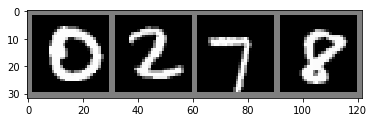

In [19]:
data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                          batch_size = 4,
                                          shuffle = True)
X_test, y_test = next(iter(data_loader_test))
inputs = Variable(X_test)
pred = model(inputs)
_,pred = torch.max(pred, 1)

print("Predict Label is:", [ i for i in pred.data])
print("Real Label is:",[i for i in y_test])

img = torchvision.utils.make_grid(X_test)
img = img.numpy().transpose(1,2,0)

std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean
plt.imshow(img)
    